In [8]:
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import numpy as np

import random

In [2]:
PIL.Image.__version__  # should be >= 8.0

'8.0.0'

In [103]:
import albumentations
import cv2
import math

def normalized_grid_distortion(
    img,
    num_steps=10,
    xsteps=(),
    ysteps=(),
    *args,
    **kwargs
):
    height, width = img.shape[:2]    

    # compensate for smaller last steps in source image.
    x_step = width // num_steps
    last_x_step = min(width, ((num_steps + 1) * x_step)) - (num_steps * x_step)
    xsteps[-1] *= last_x_step / x_step
    
    y_step = height // num_steps
    last_y_step = min(height, ((num_steps + 1) * y_step)) - (num_steps * y_step)
    ysteps[-1] *= last_y_step / y_step
    
    # now normalize such that distortion never leaves image bounds.
    tx = width / math.floor(width / num_steps)
    ty = height / math.floor(height / num_steps)
    xsteps = np.array(xsteps) * (tx / np.sum(xsteps))
    ysteps = np.array(ysteps) * (ty / np.sum(ysteps))
    
    # do actual distortion.
    return F.grid_distortion(img, num_steps, xsteps, ysteps, *args, **kwargs)
    

class NormalizedGridDistortion(albumentations.augmentations.transforms.GridDistortion):
    def apply(self, img, stepsx=(), stepsy=(), interpolation=cv2.INTER_LINEAR, **params):
        return normalized_grid_distortion(img, self.num_steps, stepsx, stepsy, interpolation, self.border_mode, self.value)

    def apply_to_mask(self, img, stepsx=(), stepsy=(), **params):
        return normalized_grid_distortion(
            img, self.num_steps, stepsx, stepsy, cv2.INTER_NEAREST, self.border_mode, self.mask_value
        )

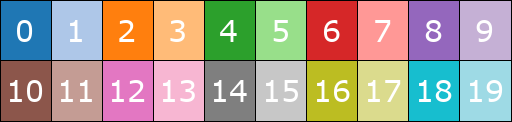

In [104]:
im_w = 512
im_h = 122

sx = 10
sy = 2

demo_image = PIL.Image.new('RGB', (im_w, im_h))

draw = PIL.ImageDraw.Draw(demo_image)
draw.rectangle(((0, 0), (im_w - 1, im_h - 1)), fill="white", outline="black")

from palettable.tableau import Tableau_20
colors = [tuple(color) for color in Tableau_20.colors]

font = PIL.ImageFont.truetype("Verdana.ttf", 30)

for ix in range(sx):
    for iy in range(sy):
        i = ix + iy * sx
        x0 = ix * ((im_w - 1) / sx)
        y0 = iy * ((im_h - 1) / sy)
        x1 = (ix + 1) * ((im_w - 1) / sx)
        y1 = (iy + 1) * ((im_h - 1) / sy)
        draw.rectangle(((x0, y0), (x1, y1)), fill=colors[i], outline="black")
        draw.text(((x0 + x1) / 2, (y0 + y1)/ 2), str(i), font=font, fill=(255, 255, 255), anchor="mm")

demo_image

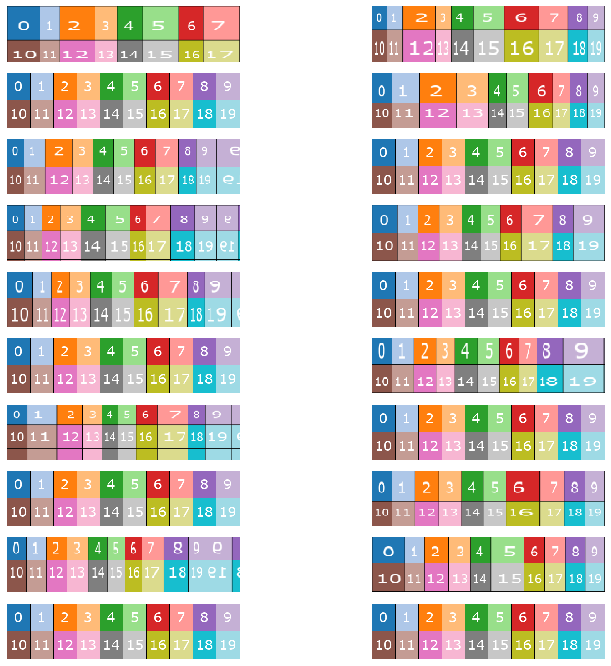

In [109]:
import albumentations as A
from matplotlib import pyplot as plt

distortion_args = dict(
    distort_limit=0.5,
    num_steps=8)

transform = A.GridDistortion(**distortion_args)
transform_normalized = NormalizedGridDistortion(**distortion_args)

plt.figure(figsize=(12, 12))

nrows = 10

for y in range(nrows):
    random.seed(7 + y * 121)

    augmented = transform(image=np.array(demo_image))
    augmented_normalized = transform_normalized(image=np.array(demo_image))
    
    plt.subplot(nrows, 2, 2 * y + 1)
    plt.imshow(augmented['image'])
    plt.axis('off')

    plt.subplot(nrows, 2, 2 * y + 2)
    plt.imshow(augmented_normalized['image'])
    plt.axis('off')
